In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path2p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

from matrices_lib import spRandUMat, spRandUMatBase, spRandUMatFromBase, mergeMatBases, outerSP

# Equation for neuron update of a single-type neuron population
def computeX_Single(x, W, T, G, p):
    nu = np.random.exponential(p['nu_avg'], p['N'])
    return (W.dot(x) + nu - G - T >= 1).astype(int)

# Equation for neuron update of a balanced exc-inh population
def computeX_Balanced(x, W_dict, T, a_SS, p):
    nu = np.random.exponential(p['nu_avg'], p['N'])
    xEXC = x[:p['N_EXC']]
    xINH = x[p['N_EXC']:]
    vEXC = W_dict['EE'].dot(xEXC) + W_dict['IE'].dot(xINH)
    vINH = W_dict['EI'].dot(xEXC)
    
    # Synaptic scaling
    vEXC *= a_SS
    
    v = np.hstack((vEXC, vINH))
    return (v + nu - T >= 1).astype(int)

# Equation for adapting threshold - single-type neuron population
def computeT_Single(T, x, p):
    Tnew = T + p['eta_T'] * (x - p['r_T'])
    return np.clip(Tnew,  p['min_T'], p['max_T'])  # Bound the threshold

# Equation for adapting threshold - balanced exc-inh population
def computeT_Balanced(T, x, p):
    T_EXC_NEW = T[:p['N_EXC']] + p['eta_T_EXC'] * (x[:p['N_EXC']] - p['r_T_EXC'])
    T_INH_NEW = T[p['N_EXC']:] + p['eta_T_INH'] * (x[p['N_EXC']:] - p['r_T_INH'])
    
    # Bound the threshold
    return np.clip(np.hstack((T_EXC_NEW, T_INH_NEW)), p['min_T'], p['max_T'])

# Update weights
def updateW(W_dict, W_BASE_dict, x, p):
    x_exc = x[:, :p['N_EXC']]
    idxRow = W_BASE_dict['EE'][1][0]
    idxCol = W_BASE_dict['EE'][1][1]
    
    HEBB_CAUS_1Dflat = outerSP(idxRow, idxCol, x_exc[-1], x_exc[-2])
    HEBB_ANTI_1Dflat = outerSP(idxRow, idxCol, x_exc[-2], x_exc[-1])
    
    W_dict['EE'].data += p['eta_STDP'] * (HEBB_CAUS_1Dflat - HEBB_ANTI_1Dflat)
    W_dict['EE'].data = np.clip(W_dict['EE'].data, p['min_W'], p['max_W'])
    
# Equation for global inhibition
def computeG(x, p):
    newG = p["eta_G"] * (np.sum(x) / p['N'] - p["x_G"])
    return np.max((0.0, newG))  # Global inhibition can't be negative

# Equation for Synaptic Scaling parameter alpha_SS
def computeAss(x, r, a_SS, p):
    rnew = r + (x - r) / p['tau_SS']
    a_SSnew = a_SS + p['eta_SS'] * (p['R0'] - np.mean(rnew))
    return rnew, np.clip(a_SSnew, p['aSS_min'], p['aSS_max'])

Appended library directory /home/alyosha/work/git/memory-hippo-ca3/lib


## Example 1.1: Fixed random network with adjustable global inhibition

Plan:
* Have discrete population of $N$ neurons $x_i \in \{0, 1\}$
* Neurons have no memory and update their state at every time step according to

$$x_i(t+1) = \Theta(W_{ij} x_j(t) + \nu_i(t) - T_i - G(t))$$

Where $W_{ij}$ are the connecting weights, $\nu_i$ is the synaptic noise, $T_i$ is the threshold of each neuron, and $G$ the global inhibition (GINH). The latter adapts over time to prevent the network from exploding.

$$G(t+1) = \eta_G \biggl(\frac{1}{N}\sum_i x_i(t) - \bar{x}\biggr)$$

Given the sparsity parameter $\alpha_W$, the expected number of neurons active at a given moment in time $\alpha_N$, and the average weight $W_0$, the average input to each neuron at a given moment in time will be $I \approx W_0 (N-1) \alpha_W \alpha_N$. In a steady state, our goal is to select $W_0$ such that $P[I > T_0] = \alpha_W$. Computing the true probability distribution is tricky. Instead, by solving $I = T_0$ we find the average weight which will result in $50\%$ of neurons crossing the threshold. Since the desired $\alpha_W$ is typically smaller than that, we can let the global inhibition downregulate it to the desired value. Thus a reasonable initial value

$$W_0 = \frac{T_0}{(N-1) \alpha_W \alpha_N}$$

**Observations**:
* Too low GINH rate - $x_i = 1$ for all neurons
* Too high GINH rate - network dies out
* Good GINH rate - network exhibits chaotic-like oscillation
* The network is really stable if global inhibition is allowed to go negative - the network operates like an oscillator and at least looks asymptotically stable. It does not seem that positive global inhibition + noise can mimic signed global inhibition. The latter is stable, the former is not.

**Problems**:
* About half of "good" networks are asymptotically unstable - they die out after a short while
* Some neurons do not participate at all in chaotic motion due to survival of the fittest

**Solutions**:
* Introduce slow homeostatic plasticity to adjust spiking rate

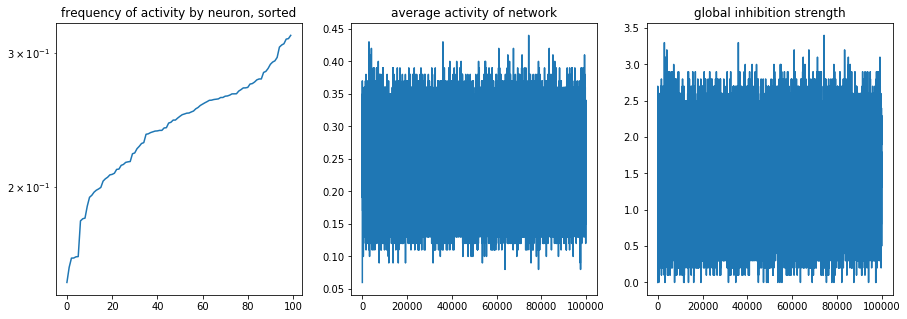

In [56]:
###############
# Initialization
###############

p = {
    "N"         : 100,   # Number of neurons
    "x_G"       : 0.1,   # Global inhibition - average activity
    "eta_G"     : 10.0,  # Global inhibition - rate
    "nu_avg"    : 0.1,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Connection probability
    "W0"        : 10.0   # Total Thresholds produced if all pre-synaptic units are active
}
#p['W0'] = 1.1 * p['T0'] / ((p['N'] - 1) * p['x_G'] * p['p_conn'])

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_G']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])
G = computeG(x, p)

# Connectivity matrix
W = spRandUMat([p['N'], p['N']], [0.9, 1.1], p['p_conn'], withDiag=False)
W = normalize(W, norm='l1', axis=1) * p['W0']

# Plot connectivity
#print('Average weight:', p['W0'])
# plt.figure()
# plt.imshow(W.toarray())
# plt.show()


###############
# Simulation
###############

N_STEP = 100000

x_hist = np.zeros((N_STEP, p['N']))
x_hist[0] = x

G_hist = np.zeros(N_STEP)
G_hist[0] = G

for i in range(N_STEP-1):
    x = computeX_Single(x, W, T, G, p)
    G = computeG(x, p)
    x_hist[i+1] = x
    G_hist[i+1] = G

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].semilogy(np.sort(np.mean(x_hist, axis=0)))
ax[1].plot(np.mean(x_hist, axis=1))
ax[2].plot(G_hist)
ax[0].set_title("frequency of activity by neuron, sorted")
ax[1].set_title("average activity of network")
ax[2].set_title("global inhibition strength")
plt.show()

## Example 1.2 Balanced network, only local inhibition, no plasticity

**Observations**:
* When there is no noise, network enters highly regular oscillatory regime
* Behaviour highly dependent on exact connectivity. Very frequently pathological

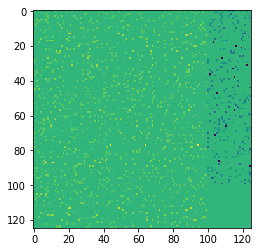

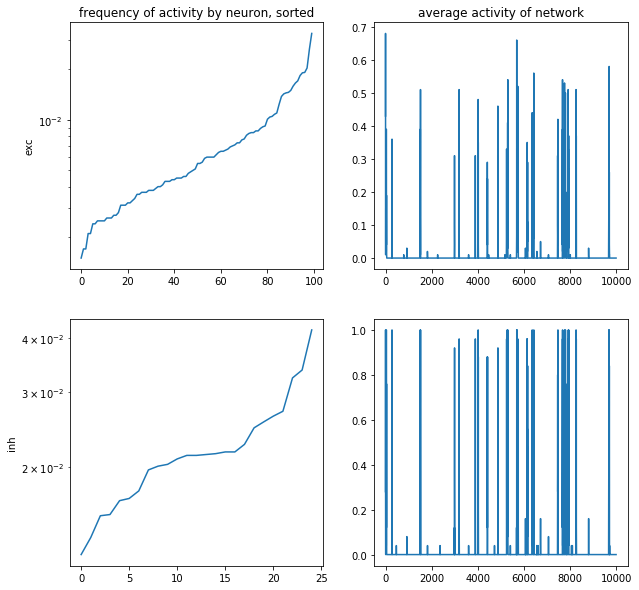

In [122]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,   # Number of excitatory neurons
    "N_INH"     : 25,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 0.2,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    "W0"        : 10.0   # Total Thresholds produced if all pre-synaptic units are active
}

# gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EE'] = p['T0'] * p['W0'] * 1.5   # * 1
p['W0_EI'] = p['T0'] * p['W0'] * 1.5  # * 1
p['W0_IE'] = p['T0'] * p['W0'] * -1.0  # * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_EE_BASE = spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False)
W_EI_BASE = spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True)
W_IE_BASE = spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)
W_BASE = mergeMatBases([W_EE_BASE, W_EI_BASE, W_IE_BASE], [0, p['N_EXC'], 0], [0, 0, p['N_EXC']])
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# Normalize Matrices
W[:p['N_EXC'], :p['N_EXC']] = normalize(W[:p['N_EXC'], :p['N_EXC']], norm='l1', axis=1) * p['W0_EE']
W[p['N_EXC']:, :p['N_EXC']] = normalize(W[:p['N_INH'], :p['N_EXC']], norm='l1', axis=1) * p['W0_EI']
W[:p['N_EXC'], p['N_EXC']:] = normalize(W[:p['N_EXC'], :p['N_INH']], norm='l1', axis=1) * p['W0_IE']

# Plot connectivity
plt.figure()
plt.imshow(W.toarray())
plt.show()


###############
# Simulation
###############

N_STEP = 10000

x_hist = np.zeros((N_STEP, p['N']))
x_hist[0] = x

for i in range(N_STEP-1):
    x = computeX_Single(x, W, T, 0.0, p)
    x_hist[i+1] = x

fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(10,10))
ax[0][0].semilogy(np.sort(np.mean(x_hist[:, :p['N_EXC']], axis=0)))
ax[1][0].semilogy(np.sort(np.mean(x_hist[:, p['N_EXC']:], axis=0)))
ax[0][1].plot(np.mean(x_hist[:, :p['N_EXC']], axis=1))
ax[1][1].plot(np.mean(x_hist[:, p['N_EXC']:], axis=1))
ax[0][0].set_title("frequency of activity by neuron, sorted")
ax[0][1].set_title("average activity of network")
ax[0][0].set_ylabel("exc")
ax[1][0].set_ylabel("inh")
plt.show()

## Example 1.3: Global Inhibition, slow homeostatic threshold

**Conclusions**:

* Long-term HP seems to make things worse - the networks which are stable under their own activity collapse to zero activity
* In presence of noise, the network still collapse to fully noise-driven.

The discrete system with global inhibition seems to have a preferred activity level. Attempt to change that level by varying threshold results in system asymptotically collapsing to zero. 

**Solutions**:
* Analytic analysis? Possibly overkill
* Full parameter sweep?
* Just move to rate model - it should not be subject to dramatic loss of energy in such a way.

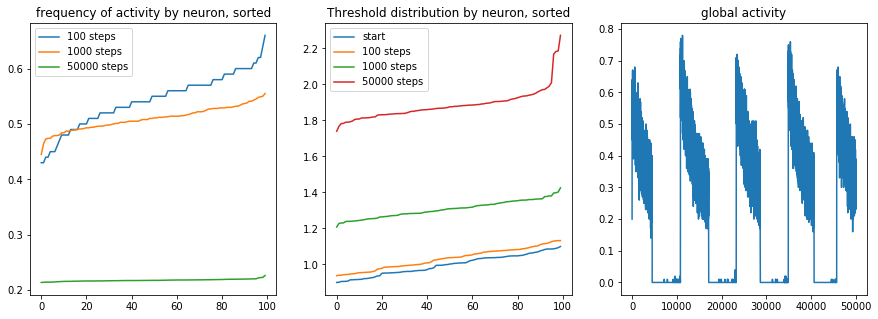

In [135]:
###############
# Initialization
#   Same as ex1.1, but with adaptive thresholds
###############

p = {
    "N"         : 100,    # Number of neurons
    "x_G"       : 0.2,    # Global inhibition - average activity
    "eta_G"     : 10.0,   # Global inhibition - rate
    "nu_avg"    : 0.2,    # Neuronal Noise - average
    "T0"        : 1.0,    # Average threshold
    "eta_T"     : 0.001,  # Threshold - homeostatic adaptation rate
    "min_T"     : 0.1,    # Threshold - homeostatic adaptation rate
    "max_T"     : 2.5,    # Threshold - homeostatic adaptation rate
    "r_T"       : 0.2,    # Threshold - homeostatic equillibtium neuron firing rate
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "W0"        : 10.0    # Total Thresholds produced if all pre-synaptic units are active
}
#p['W0'] = 1.5 * p['T0'] / ((p['N'] - 1) * p['x_G'] * p['p_conn'])

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_G']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])
G = computeG(x, p)

# Connectivity matrix
W = spRandUMat([p['N'], p['N']], [0.9, 1.1], p['p_conn'], withDiag=False)
W = normalize(W, norm='l1', axis=1) * p['W0']

# # Plot connectivity
# print('Average weight:', p['W0'])
# plt.figure()
# plt.imshow(W.to_array())
# plt.show()

###############
# Simulation
###############

N_STEP = 50000

x_hist = np.zeros((N_STEP, p['N']))
T_hist = np.zeros((N_STEP, p['N']))
G_hist = np.zeros(N_STEP)
x_hist[0] = x
T_hist[0] = T
G_hist[0] = G
    
for i in range(N_STEP-1):
    x = computeX_Single(x, W, T, G, p)
    G = computeG(x, p)
    T = computeT_Single(T, x, p)
    x_hist[i+1] = x
    T_hist[i+1] = T
    G_hist[i+1] = G
    
    T_hist[i+1]
    
    #p['nu_avg'] = 1.0 - 0.9 * i / N_STEP
    
    
###############
# Analysis
###############

freq100 = np.sort(np.sum(x_hist[:100], axis=0)) / 100
freq1000 = np.sort(np.sum(x_hist[:1000], axis=0)) / 1000
freqAll = np.sort(np.sum(x_hist, axis=0)) / N_STEP

T0    = np.sort(T_hist[0])
T100  = np.sort(T_hist[100])
T1000 = np.sort(T_hist[1000])
TLast = np.sort(T_hist[-1])
    
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(freq100, label='100 steps')
ax[0].plot(freq1000, label='1000 steps')
ax[0].plot(freqAll, label=str(N_STEP)+' steps')

ax[1].plot(T0, label='start')
ax[1].plot(T100, label='100 steps')
ax[1].plot(T1000, label='1000 steps')
ax[1].plot(TLast, label=str(N_STEP)+' steps')

ax[2].plot(np.mean(x_hist, axis=1))
#ax[2].plot(G_hist)

ax[0].set_title("frequency of activity by neuron, sorted")
ax[1].set_title("Threshold distribution by neuron, sorted")
ax[2].set_title("global activity")
#ax[2].set_title("global inhibition strength")

ax[0].legend()
ax[1].legend()
plt.show()

## 1.4 Balanced network, Slow homeostatic threshold

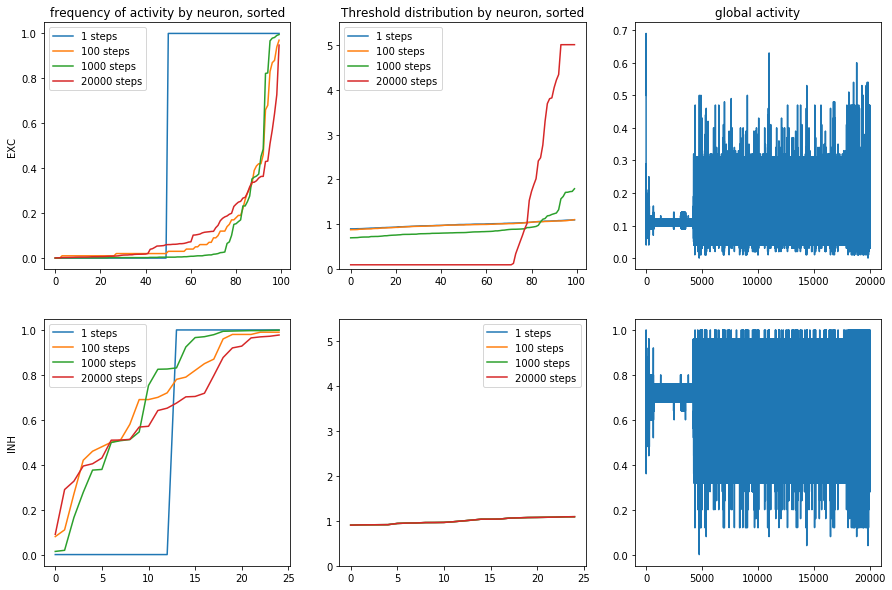

In [154]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,   # Number of excitatory neurons
    "N_INH"     : 25,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 0.2,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "eta_T_EXC" : 0.001, # Threshold - excitatory homeostatic adaptation rate
    "eta_T_INH" : 0.0,   # Threshold - inhibitory homeostatic adaptation rate
    "min_T"     : 0.1,   # Threshold - minimum
    "max_T"     : 5.0,   # Threshold - maximum
    "r_T_EXC"   : 0.2,   # Threshold - excitatory homeostatic equillibtium neuron firing rate
    "r_T_INH"   : 0.8,   # Threshold - inhibitory homeostatic equillibtium neuron firing rate
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    "W0"        : 40.0   # Total Thresholds produced if all pre-synaptic units are active
}

#gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EE'] = p['T0'] * p['W0'] * 1.2   # * 1
p['W0_EI'] = p['T0'] * p['W0'] * 1.0  # * 1
p['W0_IE'] = p['T0'] * p['W0'] * -1.0  # * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_EE_BASE = spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False)
W_EI_BASE = spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True)
W_IE_BASE = spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)
W_BASE = mergeMatBases([W_EE_BASE, W_EI_BASE, W_IE_BASE], [0, p['N_EXC'], 0], [0, 0, p['N_EXC']])
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# Normalize Matrices
W[:p['N_EXC'], :p['N_EXC']] = normalize(W[:p['N_EXC'], :p['N_EXC']], norm='l1', axis=1) * p['W0_EE']
W[p['N_EXC']:, :p['N_EXC']] = normalize(W[:p['N_INH'], :p['N_EXC']], norm='l1', axis=1) * p['W0_EI']
W[:p['N_EXC'], p['N_EXC']:] = normalize(W[:p['N_EXC'], :p['N_INH']], norm='l1', axis=1) * p['W0_IE']
# # Plot connectivity
# print('Average weight:', p['W0_EXC'])
# plt.figure()
# plt.imshow(W.toarray(), cmap='jet')
# plt.show()


###############
# Simulation
###############

N_STEP = 20000

x_hist = np.zeros((N_STEP, p['N']))
T_hist = np.zeros((N_STEP, p['N']))
x_hist[0] = x
T_hist[0] = T

for i in range(N_STEP-1):
    x = computeX_Single(x, W, T, 0.0, p)
    T = computeT_Balanced(T, x, p)
    x_hist[i+1] = x
    T_hist[i+1] = T

###############
# Analysis
###############
    
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(15, 10))

typeRange = {'EXC' : np.array(range(p['N_EXC'])), 'INH' : np.array(range(p['N_EXC'], p['N']))}
for i, ntype in enumerate(['EXC', 'INH']):
    for step in [1, 100, 1000, N_STEP]:
        ax[i][0].plot(np.sort(np.mean(x_hist[:step, typeRange[ntype]], axis=0)), label=str(step)+' steps')
        ax[i][1].plot(np.sort(T_hist[step-1, typeRange[ntype]]), label=str(step)+' steps')

    ax[i][2].plot(np.mean(x_hist[:, typeRange[ntype]], axis=1))
    
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][1].set_ylim(0, 1.1*p['max_T'])

ax[0][0].set_ylabel("EXC")
ax[1][0].set_ylabel("INH")
    
ax[0][0].set_title("frequency of activity by neuron, sorted")
ax[0][1].set_title("Threshold distribution by neuron, sorted")
ax[0][2].set_title("global activity")
#ax[2].set_title("global inhibition strength")

plt.show()

## 1.5 Balanced Network, STDP

$$W_{ij}(t+1) = W_{ij}(t) + \eta_{STDP} \bigl(x_i(t+1)x_j(t) - x_j(t+1)x_i(t) \bigr)$$

**Conclusions**: Network appears to be unstable - it either blows up or dies down to 0. Whenever there is not enough activity to self-sustain, the STDP is too slow and does not manage to catch up. Whenever there is enough energy to self-sustain, STDP grows over time

Total connections: 3980 Average weight: 10.0


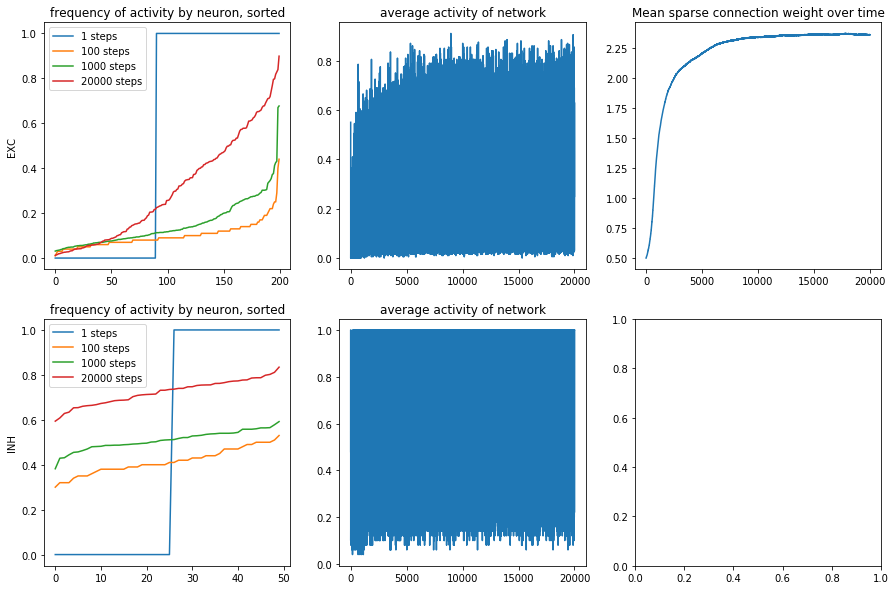

In [168]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 200,   # Number of excitatory neurons
    "N_INH"     : 50,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 1.0,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    "eta_STDP"  : 0.1,   # Rate of STDP
    "min_W"     : 0.1,   # Max weight
    "max_W"     : 4.0,   # Max weight
    "W0"        : 10.0   # Total Thresholds produced if all pre-synaptic units are active
}

#gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EE'] = p['T0'] * p['W0'] * 1.0   # * 1
p['W0_EI'] = p['T0'] * p['W0'] * 1.0  # * 1
p['W0_IE'] = p['T0'] * p['W0'] * -1.0  # * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_EE_BASE = spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False)
W_EI_BASE = spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True)
W_IE_BASE = spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)
W_BASE = mergeMatBases([W_EE_BASE, W_EI_BASE, W_IE_BASE], [0, p['N_EXC'], 0], [0, 0, p['N_EXC']])
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# Connectivity matrix
# In this case we do not create one big matrix, because STDP will change values of each matrix independently
# Store both base form and CSR, because base form contains indices we need for outer product
rangeW = np.array([0.9, 1.1])
W_BASE_dict = {
  'EE' : spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False),
  'EI' : spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True),
  'IE' : spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)    
}
W_dict = {
  'EE' : spRandUMatFromBase(W_BASE_dict['EE'], [p['N_EXC'], p['N_EXC']]),
  'EI' : spRandUMatFromBase(W_BASE_dict['EI'], [p['N_INH'], p['N_EXC']]),
  'IE' : spRandUMatFromBase(W_BASE_dict['IE'], [p['N_EXC'], p['N_INH']])
}

# Normalize Matrices
W_dict['EE'] = normalize(W_dict['EE'], norm='l1', axis=1) * p['W0_EE']
W_dict['EI'] = normalize(W_dict['EI'], norm='l1', axis=1) * p['W0_EI']
W_dict['IE'] = normalize(W_dict['IE'], norm='l1', axis=1) * p['W0_IE']

# # Plot connectivity
print('Total connections:', W_dict['EE'].data.shape[0], 'Average weight:', p['W0_EE'])
# plt.figure()
# plt.imshow(M, cmap='jet')
# plt.show()

###############
# Simulation
###############

N_STEP = 20000

x_hist = np.zeros((N_STEP, p['N']))
x_hist[0] = x
W_norm_hist = np.zeros(N_STEP)
W_norm_hist[0] = np.mean(W_dict['EE'].data)

for i in range(N_STEP-1):
    x = computeX_Balanced(x, W_dict, T, 1.0, p)
    x_hist[i+1] = x
    updateW(W_dict, W_BASE_dict, x_hist[i:i+2], p)
    
#     M = computeW(M, M_CONN, x_hist[i:i+2], p)
    W_norm_hist[i+1] = np.mean(W_dict['EE'].data)

###############
# Analysis
###############

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

typeRange = {'EXC' : np.array(range(p['N_EXC'])), 'INH' : np.array(range(p['N_EXC'], p['N']))}
for i, ntype in enumerate(['EXC', 'INH']):
    for step in [1, 100, 1000, N_STEP]:
        ax[i][0].plot(np.sort(np.mean(x_hist[:step, typeRange[ntype]], axis=0)), label=str(step)+' steps')

    ax[i][1].plot(np.mean(x_hist[:, typeRange[ntype]], axis=1))
    ax[i][0].set_title("frequency of activity by neuron, sorted")
    ax[i][1].set_title("average activity of network")
    ax[i][0].legend()
    ax[i][0].set_ylabel(ntype)
    
ax[0][2].plot(W_norm_hist)
ax[0][2].set_title("Mean sparse connection weight over time")
plt.show()

## 1.6 Balanced Network, STDP + HP

**Conclusions**: Nope, still unstable. After looking for a while for stable regimes, I only see either explosion, or  0-activity state with occasional huge bursts. Thus it is entirely noise-driven, and does not maintain any continuous dynamics

Total connections: 3980 Average weight: 10.0


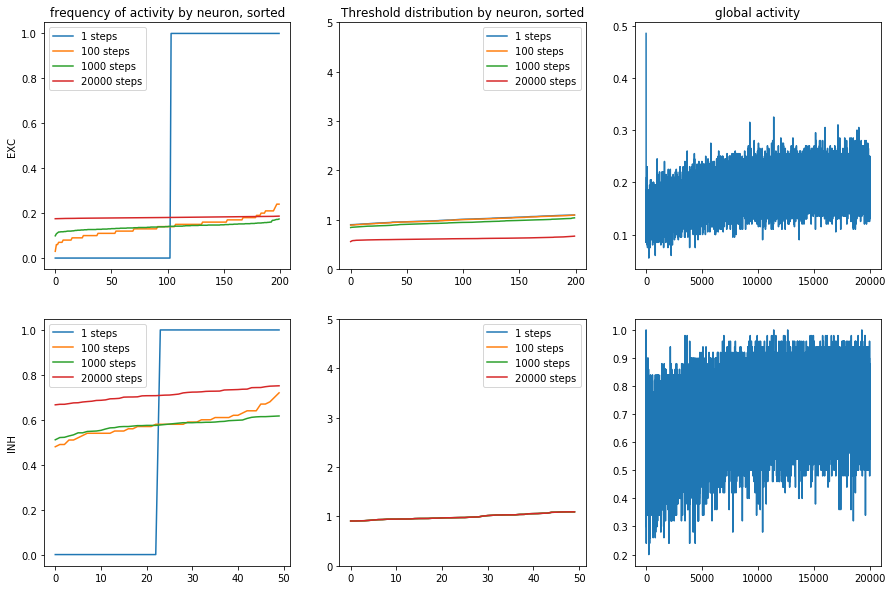

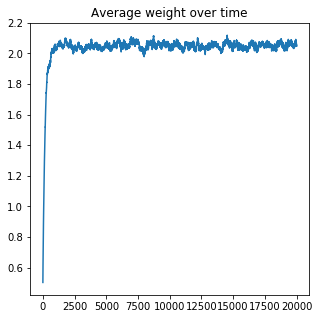

In [165]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 200,   # Number of excitatory neurons
    "N_INH"     : 50,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 1.0,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    "eta_STDP"  : 1.0,   # Rate of STDP
    "min_W"     : 0.1,   # Max weight
    "max_W"     : 4.0,   # Max weight
    "eta_T_EXC" : 0.001, # Threshold - excitatory homeostatic adaptation rate
    "eta_T_INH" : 0.0,   # Threshold - inhibitory homeostatic adaptation rate
    "min_T"     : 0.1,   # Threshold - minimum
    "max_T"     : 5.0,   # Threshold - maximum
    "r_T_EXC"   : 0.2,   # Threshold - excitatory homeostatic equillibtium neuron firing rate
    "r_T_INH"   : 0.8,   # Threshold - inhibitory homeostatic equillibtium neuron firing rate
    "W0"        : 10.0   # Total Thresholds produced if all pre-synaptic units are active
}

#gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EE'] = p['T0'] * p['W0'] * 1.0   # * 1
p['W0_EI'] = p['T0'] * p['W0'] * 1.0  # * 1
p['W0_IE'] = p['T0'] * p['W0'] * -1.0  # * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_EE_BASE = spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False)
W_EI_BASE = spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True)
W_IE_BASE = spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)
W_BASE = mergeMatBases([W_EE_BASE, W_EI_BASE, W_IE_BASE], [0, p['N_EXC'], 0], [0, 0, p['N_EXC']])
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# Connectivity matrix
# In this case we do not create one big matrix, because STDP will change values of each matrix independently
# Store both base form and CSR, because base form contains indices we need for outer product
rangeW = np.array([0.9, 1.1])
W_BASE_dict = {
  'EE' : spRandUMatBase([p['N_EXC'], p['N_EXC']], rangeW, p['p_conn'], withDiag=False),
  'EI' : spRandUMatBase([p['N_INH'], p['N_EXC']], rangeW, p['p_conn'], withDiag=True),
  'IE' : spRandUMatBase([p['N_EXC'], p['N_INH']], rangeW, p['p_conn'], withDiag=True)    
}
W_dict = {
  'EE' : spRandUMatFromBase(W_BASE_dict['EE'], [p['N_EXC'], p['N_EXC']]),
  'EI' : spRandUMatFromBase(W_BASE_dict['EI'], [p['N_INH'], p['N_EXC']]),
  'IE' : spRandUMatFromBase(W_BASE_dict['IE'], [p['N_EXC'], p['N_INH']])
}

# Normalize Matrices
W_dict['EE'] = normalize(W_dict['EE'], norm='l1', axis=1) * p['W0_EE']
W_dict['EI'] = normalize(W_dict['EI'], norm='l1', axis=1) * p['W0_EI']
W_dict['IE'] = normalize(W_dict['IE'], norm='l1', axis=1) * p['W0_IE']

# # Plot connectivity
print('Total connections:', W_dict['EE'].data.shape[0], 'Average weight:', p['W0_EE'])
# plt.figure()
# plt.imshow(M, cmap='jet')
# plt.show()

###############
# Simulation
###############

N_STEP = 20000

x_hist = np.zeros((N_STEP, p['N']))
x_hist[0] = x
T_hist = np.zeros((N_STEP, p['N']))
T_hist[0] = T
W_hist = np.zeros(N_STEP)
W_hist[0] = np.mean(W_dict['EE'].data)

for i in range(N_STEP-1):
    #p["nu_avg"] = 1.0 + 1.0 * np.exp(-i/10000)
    
    x = computeX_Balanced(x, W_dict, T, 0.0, p)
    T = computeT_Balanced(T, x, p)
    
    x_hist[i+1] = x
    T_hist[i+1] = T
    
    updateW(W_dict, W_BASE_dict, x_hist[i:i+2], p)
    W_hist[i+1] = np.mean(W_dict['EE'].data)

###############
# Analysis
###############

fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(15, 10))

typeRange = {'EXC' : np.array(range(p['N_EXC'])), 'INH' : np.array(range(p['N_EXC'], p['N']))}
for i, ntype in enumerate(['EXC', 'INH']):
    for step in [1, 100, 1000, N_STEP]:
        ax[i][0].plot(np.sort(np.mean(x_hist[:step, typeRange[ntype]], axis=0)), label=str(step)+' steps')
        ax[i][1].plot(np.sort(T_hist[step-1, typeRange[ntype]]), label=str(step)+' steps')

    ax[i][2].plot(np.mean(x_hist[:, typeRange[ntype]], axis=1))
    
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][1].set_ylim(0, p['max_T'])

ax[0][0].set_ylabel("EXC")
ax[1][0].set_ylabel("INH")
    
ax[0][0].set_title("frequency of activity by neuron, sorted")
ax[0][1].set_title("Threshold distribution by neuron, sorted")
ax[0][2].set_title("global activity")
#ax[2].set_title("global inhibition strength")

plt.show()

plt.figure(figsize=(5,5))
plt.plot(W_hist)
plt.title("Average weight over time")
plt.show()

## Example 1.7 - Balanced Network, Global Synaptic Scaling

Synaptic scaling (SS) is a multiplicative form of global homeostatic plasticity.

$$W_{ij} \rightarrow \alpha_{SS}(t) W_{ij}$$

The aim of SS is to keep neuronal firing within a healthy range on a very slow timescale. A hypothetical plasticity rule could be

$$\dot{\alpha}_{SS} = \eta_{SS} \biggl(R_0 - \frac{1}{N} \sum_{i=1}^N R_i(t) \biggr)$$

In the simplest case, $R_i(t) = S_i(t)$, but the slow timescale of this plasticity suggests that it rather accumulates the spikes

$$\dot{R}_i(t) = -\frac{R_i(t)}{\tau_{SS}} + S_i(t)$$

**Conclusions**:
* Noise-driven activity seems mostly stable, but potential well is rather shallow
* Perturbations to the network (like change of input noise) can lead it to die out or go into pathologic supersynchronization

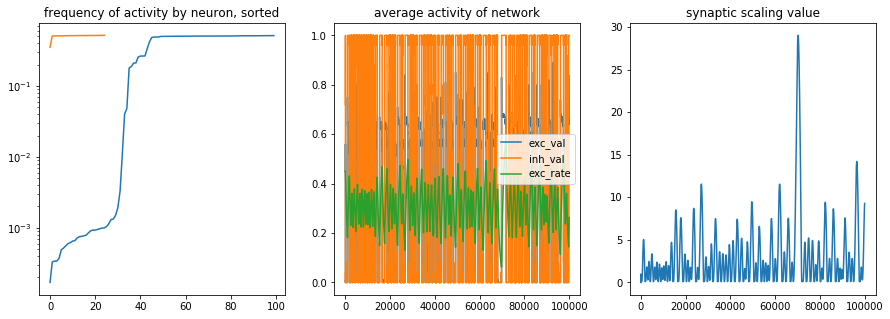

In [47]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,   # Number of excitatory neurons
    "N_INH"     : 25,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 0.2,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    
    "R0"        : 0.3,   # Average target activity rate of the network
    "tau_SS"    : 1000,  # Synaptic Scaling reaction timescale
    "eta_SS"    : 0.1,   # Synaptic Scaling effect magnitude
    "aSS_min"   : 0.1,   # Minimal synaptic scaling
    "aSS_max"   : 100.0  # Maximal synaptic scaling
}

gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EXC'] = p['T0'] * 2   # * gain
p['W0_INH'] = p['T0'] * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])
r_exc = np.copy(x[:p['N_EXC']])
a_SS = 1.0

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_dict = {
  'EE' : spRandUMat([p['N_EXC'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=False),
  'EI' : spRandUMat([p['N_INH'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=True),
  'IE' : spRandUMat([p['N_EXC'], p['N_INH']], p['W0_INH']*rangeW, p['p_conn'], withDiag=True)    
}

# # Plot connectivity
# print('Average weight:', p['W0_EXC'])
# plt.figure()
# plt.imshow(W.toarray(), cmap='jet')
# plt.show()


###############
# Simulation
###############

N_STEP = 100000

x_exc_hist = np.zeros((N_STEP, p['N_EXC']))
x_inh_hist = np.zeros((N_STEP, p['N_INH']))
r_exc_hist = np.zeros((N_STEP, p['N_EXC']))
aSS_hist = np.zeros(N_STEP)
x_exc_hist[0] = x[:p['N_EXC']]
x_inh_hist[0] = x[p['N_EXC']:]
r_exc_hist[0] = r_exc

for i in range(N_STEP-1):    
    x = computeX_Balanced(x, W_dict, T, a_SS, p)
    r_exc, a_SS = computeAss(x[:p['N_EXC']], r_exc, a_SS, p)
    
    x_exc_hist[i+1] = x[:p['N_EXC']]
    x_inh_hist[i+1] = x[p['N_EXC']:]
    r_exc_hist[i+1] = r_exc
    aSS_hist[i+1] = a_SS

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].semilogy(np.sort(np.mean(x_exc_hist, axis=0)), label='exc')
ax[0].semilogy(np.sort(np.mean(x_inh_hist, axis=0)), label='inh')
ax[1].plot(np.mean(x_exc_hist, axis=1), label='exc_val')
ax[1].plot(np.mean(x_inh_hist, axis=1), label='inh_val')
ax[1].plot(np.mean(r_exc_hist, axis=1), label='exc_rate')
ax[2].plot(aSS_hist)
ax[0].set_title("frequency of activity by neuron, sorted")
ax[1].set_title("average activity of network")
ax[2].set_title("synaptic scaling value")
ax[1].legend()
plt.show()

## Example 1.8 Balanced Network, Global Synaptic Scaling + HP

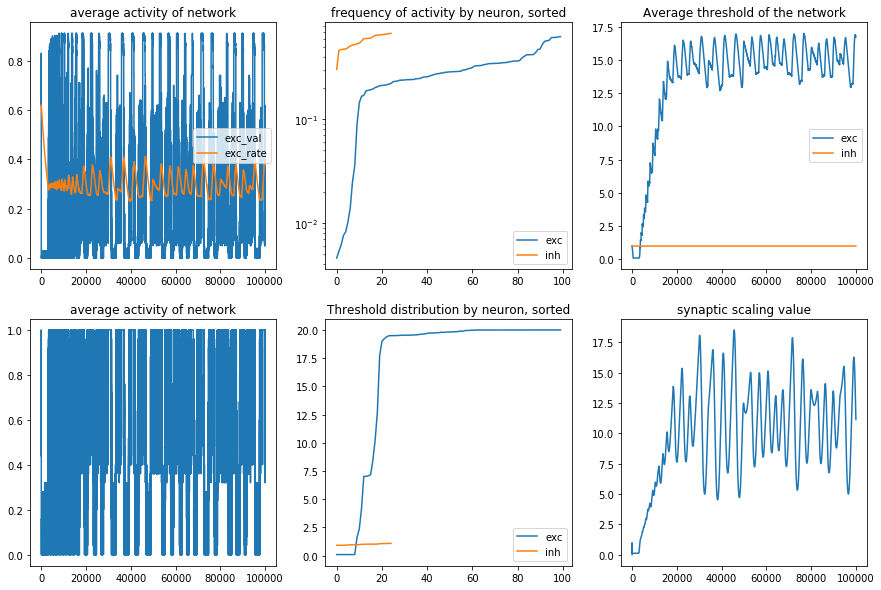

In [69]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,   # Number of excitatory neurons
    "N_INH"     : 25,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 0.2,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    
    "eta_T_EXC" : 0.01,  # Threshold - excitatory homeostatic adaptation rate
    "eta_T_INH" : 0.0,   # Threshold - inhibitory homeostatic adaptation rate
    "min_T"     : 0.1,   # Threshold - minimum
    "max_T"     : 20.0,  # Threshold - maximum
    "r_T_EXC"   : 0.2,   # Threshold - excitatory homeostatic equillibtium neuron firing rate
    "r_T_INH"   : 0.8,   # Threshold - inhibitory homeostatic equillibtium neuron firing rate
    
    "R0"        : 0.3,   # Average target activity rate of the network
    "tau_SS"    : 4000,  # Synaptic Scaling reaction timescale
    "eta_SS"    : 0.1,   # Synaptic Scaling effect magnitude
    "aSS_min"   : 0.1,   # Minimal synaptic scaling
    "aSS_max"   : 100.0  # Maximal synaptic scaling
}

gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EXC'] = p['T0'] * 2   # * gain
p['W0_INH'] = p['T0'] * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])
r_exc = np.copy(x[:p['N_EXC']])
a_SS = 1.0

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_dict = {
  'EE' : spRandUMat([p['N_EXC'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=False),
  'EI' : spRandUMat([p['N_INH'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=True),
  'IE' : spRandUMat([p['N_EXC'], p['N_INH']], p['W0_INH']*rangeW, p['p_conn'], withDiag=True)    
}

# # Plot connectivity
# print('Average weight:', p['W0_EXC'])
# plt.figure()
# plt.imshow(W.toarray(), cmap='jet')
# plt.show()


###############
# Simulation
###############

N_STEP = 100000

x_exc_hist = np.zeros((N_STEP, p['N_EXC']))
x_inh_hist = np.zeros((N_STEP, p['N_INH']))
T_exc_hist = np.zeros((N_STEP, p['N_EXC']))
T_inh_hist = np.zeros((N_STEP, p['N_INH']))
r_exc_hist = np.zeros((N_STEP, p['N_EXC']))
aSS_hist = np.zeros(N_STEP)
x_exc_hist[0] = x[:p['N_EXC']]
x_inh_hist[0] = x[p['N_EXC']:]
r_exc_hist[0] = r_exc
T_exc_hist[0] = T[:p['N_EXC']]
T_inh_hist[0] = T[p['N_EXC']:]

for i in range(N_STEP-1):    
    x = computeX_Balanced(x, W_dict, T, a_SS, p)
    r_exc, a_SS = computeAss(x[:p['N_EXC']], r_exc, a_SS, p)
    T = computeT_Balanced(T, x, p)
    
    x_exc_hist[i+1] = x[:p['N_EXC']]
    x_inh_hist[i+1] = x[p['N_EXC']:]
    T_exc_hist[i+1] = T[:p['N_EXC']]
    T_inh_hist[i+1] = T[p['N_EXC']:]
    r_exc_hist[i+1] = r_exc
    aSS_hist[i+1] = a_SS

    
    
###############
# Analysis
###############

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ax[0][0].plot(np.mean(x_exc_hist, axis=1), label='exc_val')
ax[0][0].plot(np.mean(r_exc_hist, axis=1), label='exc_rate')
ax[1][0].plot(np.mean(x_inh_hist, axis=1))

ax[0][1].semilogy(np.sort(np.mean(x_exc_hist, axis=0)), label='exc')
ax[0][1].semilogy(np.sort(np.mean(x_inh_hist, axis=0)), label='inh')
ax[1][1].plot(np.sort(T_exc_hist[-1]), label='exc')
ax[1][1].plot(np.sort(T_inh_hist[-1]), label='inh')

ax[0][2].plot(np.mean(T_exc_hist, axis=1), label='exc')
ax[0][2].plot(np.mean(T_inh_hist, axis=1), label='inh')
ax[1][2].plot(aSS_hist)


ax[0][0].set_title("average activity of network")
ax[1][0].set_title("average activity of network")
ax[0][1].set_title("frequency of activity by neuron, sorted")
ax[1][1].set_title("Threshold distribution by neuron, sorted")
ax[0][2].set_title("Average threshold of the network")
ax[1][2].set_title("synaptic scaling value")

ax[0][0].legend()
ax[0][1].legend()
ax[1][1].legend()
ax[0][2].legend()
plt.show()

## Example 1.9 Balanced Network, Global Synaptic Scaling + HP + STDP

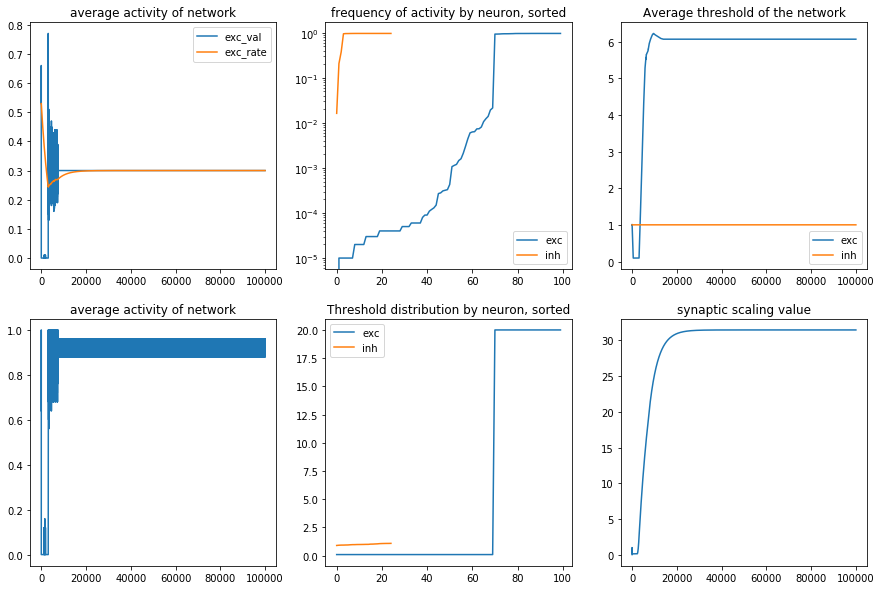

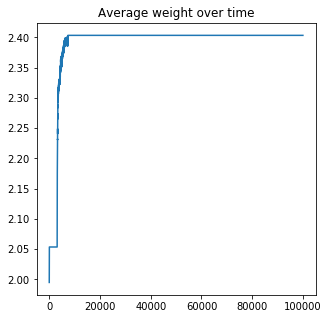

In [91]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,   # Number of excitatory neurons
    "N_INH"     : 25,    # Number of inhibitory neurons
    "x_0"       : 0.5,   # Average expected activity
    "nu_avg"    : 0.1,   # Neuronal Noise - average
    "T0"        : 1.0,   # Average threshold
    "p_conn"    : 0.1,   # Ratio of number of existing connections to all-to-all
    
    "eta_STDP"  : 0.5,   # Rate of STDP
    "min_W"     : 0.1,   # Max weight
    "max_W"     : 5.0,   # Max weight
    
    "eta_T_EXC" : 0.01,  # Threshold - excitatory homeostatic adaptation rate
    "eta_T_INH" : 0.0,   # Threshold - inhibitory homeostatic adaptation rate
    "min_T"     : 0.1,   # Threshold - minimum
    "max_T"     : 20.0,  # Threshold - maximum
    "r_T_EXC"   : 0.2,   # Threshold - excitatory homeostatic equillibtium neuron firing rate
    "r_T_INH"   : 0.8,   # Threshold - inhibitory homeostatic equillibtium neuron firing rate
    
    "R0"        : 0.3,   # Average target activity rate of the network
    "tau_SS"    : 4000,  # Synaptic Scaling reaction timescale
    "eta_SS"    : 0.1,   # Synaptic Scaling effect magnitude
    "aSS_min"   : 0.1,   # Minimal synaptic scaling
    "aSS_max"   : 100.0  # Maximal synaptic scaling
}

gain = 1 + 1 / (p['N_EXC'] * p['p_conn'])
p['N'] = p['N_EXC'] + p['N_INH']
p['W0_EXC'] = p['T0'] * 2   # * gain
p['W0_INH'] = p['T0'] * -4

# Initial values for variables
x = (np.random.uniform(0, 1, p['N']) < p['x_0']).astype(int)
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])
r_exc = np.copy(x[:p['N_EXC']])
a_SS = 1.0

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_BASE_dict = {
  'EE' : spRandUMatBase([p['N_EXC'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=False),
  'EI' : spRandUMatBase([p['N_INH'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=True),
  'IE' : spRandUMatBase([p['N_EXC'], p['N_INH']], p['W0_INH']*rangeW, p['p_conn'], withDiag=True)    
}
W_dict = {
  'EE' : spRandUMatFromBase(W_BASE_dict['EE'], [p['N_EXC'], p['N_EXC']]),
  'EI' : spRandUMatFromBase(W_BASE_dict['EI'], [p['N_INH'], p['N_EXC']]),
  'IE' : spRandUMatFromBase(W_BASE_dict['IE'], [p['N_EXC'], p['N_INH']])
}


# # Plot connectivity
# print('Average weight:', p['W0_EXC'])
# plt.figure()
# plt.imshow(W.toarray(), cmap='jet')
# plt.show()


###############
# Simulation
###############

N_STEP = 100000

x_exc_hist = np.zeros((N_STEP, p['N_EXC']))
x_inh_hist = np.zeros((N_STEP, p['N_INH']))
T_exc_hist = np.zeros((N_STEP, p['N_EXC']))
T_inh_hist = np.zeros((N_STEP, p['N_INH']))
r_exc_hist = np.zeros((N_STEP, p['N_EXC']))
aSS_hist = np.zeros(N_STEP)
x_exc_hist[0] = x[:p['N_EXC']]
x_inh_hist[0] = x[p['N_EXC']:]
r_exc_hist[0] = r_exc
T_exc_hist[0] = T[:p['N_EXC']]
T_inh_hist[0] = T[p['N_EXC']:]
W_hist = np.zeros(N_STEP)
W_hist[0] = np.mean(W_dict['EE'].data)

for i in range(N_STEP-1):    
    x = computeX_Balanced(x, W_dict, T, a_SS, p)
    r_exc, a_SS = computeAss(x[:p['N_EXC']], r_exc, a_SS, p)
    T = computeT_Balanced(T, x, p)
    
    x_exc_hist[i+1] = x[:p['N_EXC']]
    x_inh_hist[i+1] = x[p['N_EXC']:]
    T_exc_hist[i+1] = T[:p['N_EXC']]
    T_inh_hist[i+1] = T[p['N_EXC']:]
    r_exc_hist[i+1] = r_exc
    aSS_hist[i+1] = a_SS
    
    updateW(W_dict, W_BASE_dict, np.hstack((x_exc_hist[i:i+2], x_inh_hist[i:i+2])), p)
    W_hist[i+1] = np.mean(W_dict['EE'].data)
    
    #print(np.min(W_dict['EE'].data), np.max(W_dict['EE'].data))

    
###############
# Analysis
###############

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ax[0][0].plot(np.mean(x_exc_hist, axis=1), label='exc_val')
ax[0][0].plot(np.mean(r_exc_hist, axis=1), label='exc_rate')
ax[1][0].plot(np.mean(x_inh_hist, axis=1))

ax[0][1].semilogy(np.sort(np.mean(x_exc_hist, axis=0)), label='exc')
ax[0][1].semilogy(np.sort(np.mean(x_inh_hist, axis=0)), label='inh')
ax[1][1].plot(np.sort(T_exc_hist[-1]), label='exc')
ax[1][1].plot(np.sort(T_inh_hist[-1]), label='inh')

ax[0][2].plot(np.mean(T_exc_hist, axis=1), label='exc')
ax[0][2].plot(np.mean(T_inh_hist, axis=1), label='inh')
ax[1][2].plot(aSS_hist)


ax[0][0].set_title("average activity of network")
ax[1][0].set_title("average activity of network")
ax[0][1].set_title("frequency of activity by neuron, sorted")
ax[1][1].set_title("Threshold distribution by neuron, sorted")
ax[0][2].set_title("Average threshold of the network")
ax[1][2].set_title("synaptic scaling value")

ax[0][0].legend()
ax[0][1].legend()
ax[1][1].legend()
ax[0][2].legend()
plt.show()


plt.figure(figsize=(5,5))
plt.plot(W_hist)
plt.title("Average weight over time")
plt.show()